In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

from src.dataset.chess_dataframe import ChessDataFrame, Sizes
from logging_config import setup_logging

# Setup logging
logger = setup_logging()

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")

# I need to make csv batches of data and uploads it to huggingface
dataset = ChessDataFrame(size=Sizes.extra_smol)
logger.info("Successfully initialized ChessDataset")

/Users/youcefboumar/PycharmProjects/ChessAI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


09:50:22 - chessAI - INFO Using device: mps
09:50:22 - chessAI - INFO Initializing ChessDataset
09:50:22 - chessAI - INFO Repository Youcef/chessGames already exists
09:50:22 - chessAI - INFO Dataset does not exist, creating...
09:50:22 - chessAI - INFO Reading parsed_lichess_db_standard_rated_2024-08.pgn...
09:50:23 - chessAI - INFO Read 1000 games. Valid: 56, Invalid: 943, Ratio: 0.06
09:50:24 - chessAI - INFO Read 2000 games. Valid: 101, Invalid: 1898, Ratio: 0.05
09:50:25 - chessAI - INFO Read 3000 games. Valid: 154, Invalid: 2845, Ratio: 0.05
09:50:26 - chessAI - INFO Read 4000 games. Valid: 211, Invalid: 3788, Ratio: 0.06
09:50:27 - chessAI - INFO Read 5000 games. Valid: 265, Invalid: 4734, Ratio: 0.06
09:50:28 - chessAI - INFO Read 6000 games. Valid: 323, Invalid: 5676, Ratio: 0.06
09:50:29 - chessAI - INFO Read 7000 games. Valid: 379, Invalid: 6620, Ratio: 0.06
09:50:30 - chessAI - INFO Read 8000 games. Valid: 431, Invalid: 7568, Ratio: 0.06
09:50:31 - chessAI - INFO Read 9000 

In [9]:
game1 = dataset.df_train.iloc[0]
game1

Result                                                           1
WhiteElo                                                      1288
BlackElo                                                      1287
Player           [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, ...
Time             [1.0, 1.0, 1.0, 1.0, 0.9833333333333333, 1.0, ...
Eval             [0.15, 0.21, 0.11, 0.53, 0.17, 0.27, 0.25, 0.3...
Raw Eval         [0.15, 0.21, 0.11, 0.53, 0.17, 0.27, 0.25, 0.3...
Board            [rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR...
UCI              [e2e4, e7e5, g1f3, d7d6, c2c3, f7f5, e4f5, c8f...
MovingPiece      [P, p, N, p, P, p, P, b, P, p, N, p, P, n, P, ...
CapturedPiece    [None, None, None, None, None, None, p, P, Non...
Name: 29, dtype: object

b -> c8f5 and captures P


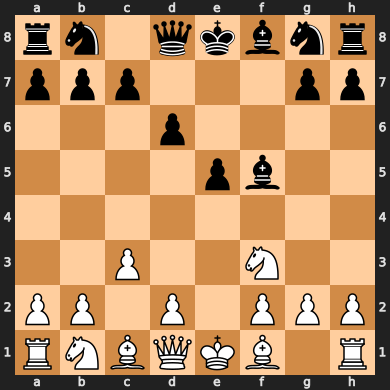

In [24]:
from chess import Board

round = 7
board = Board(game1["Board"][round])
move = game1["UCI"][round]
movingPiece = game1["MovingPiece"][round]
capturedPiece = game1["CapturedPiece"][round]
print(f"{movingPiece} -> {move} and captures {capturedPiece}")
board

In [11]:
from src.dataset.helpers import board_fen_to_image

def arr_to_imgs(arr):
    return [board_fen_to_image(x) for x in arr]

def afloat(arr):
    return [float(x) for x in arr]

train_X = np.stack(dataset.df_train["Board"].apply(arr_to_imgs).to_numpy())


ValueError: all input arrays must have the same shape

In [10]:
train_X.shape

(800,)

In [40]:
def arr_to_imgs(arr):
    return [board_fen_to_image(x) for x in arr]

def afloat(arr):
    return [float(x) for x in arr]

train_X = np.concatenate(dataset.df_train["Board"].apply(arr_to_imgs).to_numpy())
test_X = np.concatenate(dataset.df_test["Board"].apply(arr_to_imgs).to_numpy())
train_Y = np.clip(
    np.concatenate(dataset.df_train["Eval"].apply(afloat).to_numpy(), dtype=np.float32),
    -20,
    20
) / 20.0  # Normalize to [-1, 1] by dividing by max magnitude

test_Y = np.clip(
    np.concatenate(dataset.df_test["Eval"].apply(afloat).to_numpy(), dtype=np.float32), 
    -20,
    20
) / 20.0  # Normalize to [-1, 1] by dividing by max magnitude


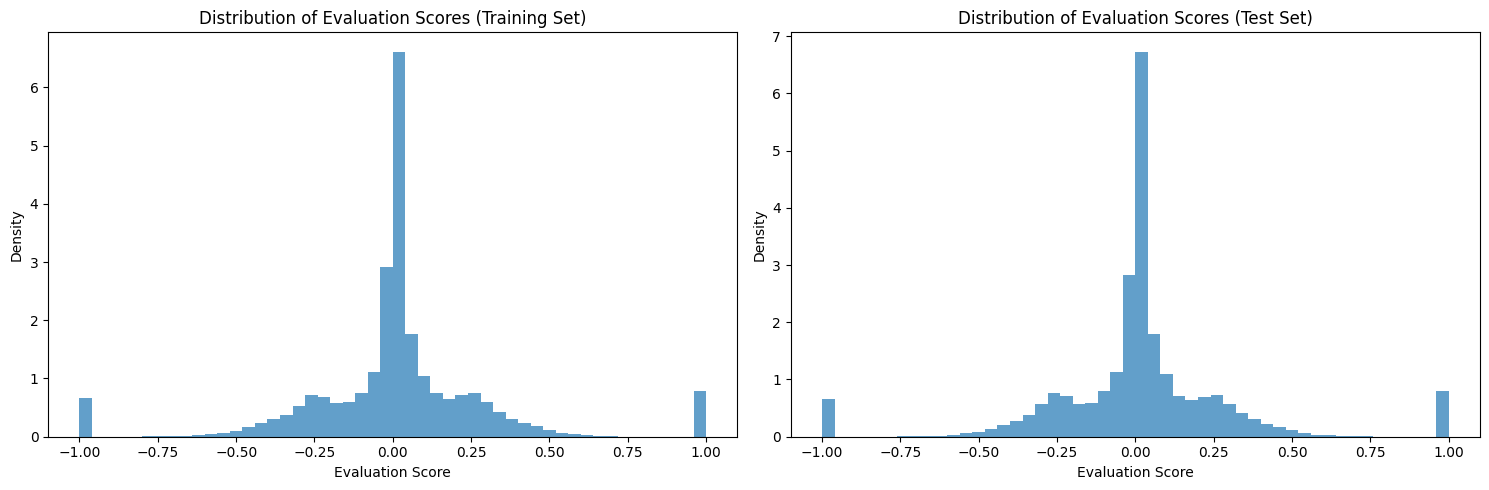


Training Set Statistics:
Mean: 0.014
Std: 0.305
Min: -1.000
Max: 1.000

Test Set Statistics:
Mean: 0.014
Std: 0.303
Min: -1.000
Max: 1.000


In [41]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 5))

# Training data distribution
plt.subplot(1, 2, 1)
plt.hist(train_Y, bins=50, density=True, alpha=0.7)
plt.title('Distribution of Evaluation Scores (Training Set)')
plt.xlabel('Evaluation Score')
plt.ylabel('Density')

# Test data distribution
plt.subplot(1, 2, 2)
plt.hist(test_Y, bins=50, density=True, alpha=0.7)
plt.title('Distribution of Evaluation Scores (Test Set)')
plt.xlabel('Evaluation Score')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Print some basic statistics
print("\nTraining Set Statistics:")
print(f"Mean: {np.mean(train_Y):.3f}")
print(f"Std: {np.std(train_Y):.3f}")
print(f"Min: {np.min(train_Y):.3f}")
print(f"Max: {np.max(train_Y):.3f}")

print("\nTest Set Statistics:")
print(f"Mean: {np.mean(test_Y):.3f}")
print(f"Std: {np.std(test_Y):.3f}")
print(f"Min: {np.min(test_Y):.3f}")
print(f"Max: {np.max(test_Y):.3f}")

In [42]:
train_X.shape

(367006, 12, 8, 8)

In [43]:
train_Y.shape

(367006,)

In [15]:
train_Y[0]

np.float32(0.17)

In [16]:
train_X[0]

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

In [44]:
class ChessEvalNet(nn.Module):
    def __init__(self):
        super(ChessEvalNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Convolutional blocks
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        
        # Flatten and fully connected layers
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# Create model and move to device
model = ChessEvalNet().to(device)

# Convert data to tensors and create DataLoader
X_train = torch.FloatTensor(train_X).to(device)
y_train = torch.FloatTensor(train_Y).to(device)
X_test = torch.FloatTensor(test_X).to(device)
y_test = torch.FloatTensor(test_Y).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def evaluate_model(model_to_eval, data_loader_eval):
    model_to_eval.eval()
    eval_total_loss = 0
    with torch.no_grad():
        for batch_x, batch_Y in data_loader_eval:
            batch_outputs = model_to_eval(batch_x)
            batch_loss = criterion(batch_outputs.squeeze(), batch_Y)
            eval_total_loss += batch_loss.item()
    return eval_total_loss / len(data_loader_eval)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Calculate losses
    train_loss = total_loss / len(train_loader)
    test_loss = evaluate_model(model, test_loader)
    
    # Print epoch statistics
    logger.info(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

19:06:33 - chessAI - INFO Epoch [1/10], Train Loss: 0.0537, Test Loss: 0.0463
19:08:09 - chessAI - INFO Epoch [2/10], Train Loss: 0.0365, Test Loss: 0.0402
19:09:46 - chessAI - INFO Epoch [3/10], Train Loss: 0.0331, Test Loss: 0.0381
19:11:28 - chessAI - INFO Epoch [4/10], Train Loss: 0.0300, Test Loss: 0.0404
19:12:58 - chessAI - INFO Epoch [5/10], Train Loss: 0.0271, Test Loss: 0.0372
19:15:10 - chessAI - INFO Epoch [6/10], Train Loss: 0.0247, Test Loss: 0.0405



KeyboardInterrupt



In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calculate_metrics(model, data_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            # Denormalize predictions and targets
            predictions = outputs.squeeze().cpu().numpy() * EVAL_STD + EVAL_MEAN
            targets = batch_y.cpu().numpy() * EVAL_STD + EVAL_MEAN
            
            all_predictions.extend(predictions)
            all_targets.extend(targets)
    
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    r2 = r2_score(all_targets, all_predictions)
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    }

# Calculate metrics for both training and test sets
train_metrics = calculate_metrics(model, train_loader)
test_metrics = calculate_metrics(model, test_loader)

# Print results
logger.info("Training Set Metrics:")
for metric, value in train_metrics.items():
    logger.info(f"{metric}: {value:.4f}")

logger.info("\nTest Set Metrics:")
for metric, value in test_metrics.items():
    logger.info(f"{metric}: {value:.4f}")

18:54:10 - chessAI - INFO Training Set Metrics:
18:54:10 - chessAI - INFO MAE: 2.9221
18:54:10 - chessAI - INFO RMSE: 8.5366
18:54:10 - chessAI - INFO R²: -0.0000
18:54:10 - chessAI - INFO 
Test Set Metrics:
18:54:10 - chessAI - INFO MAE: 2.8226
18:54:10 - chessAI - INFO RMSE: 7.8625
18:54:10 - chessAI - INFO R²: -0.0000
